# Imports

In [49]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import re
from bs4 import BeautifulSoup
%matplotlib inline

# Load Data Sets

In [50]:
df = pd.read_json('News_Category_Dataset_v2.json/News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [56]:
df[df['authors']== ''] = 'Patrick Cockburn'

# Data Prepration

In [61]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)

In [62]:
df['news']= [df.loc[x, 'headline']+ ". " + df.loc[x,'short_description'] +" "+ df.loc[x,'authors'] for x in range(len(df))]

In [63]:
df = df[pd.notnull(df['news'])]

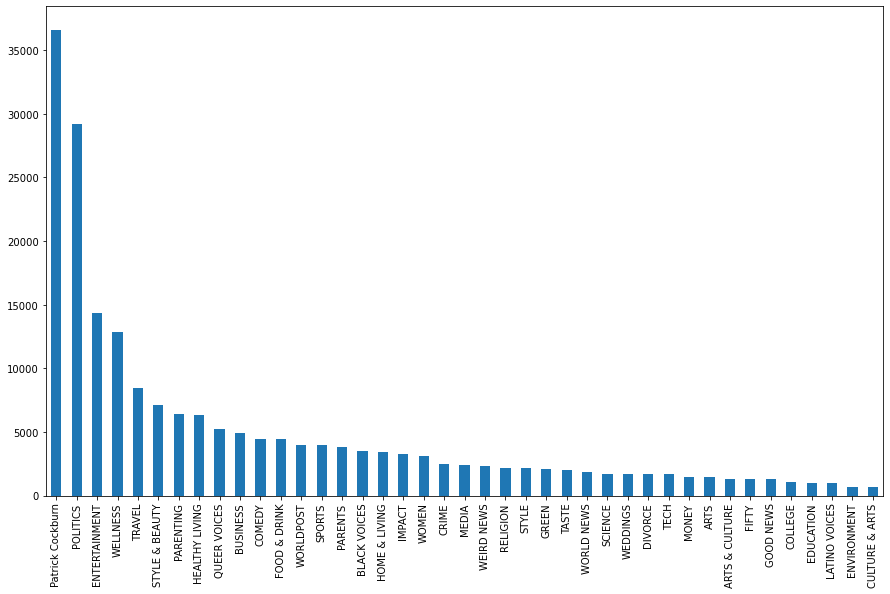

In [64]:
plt.figure(figsize=(15,9))
df.category.value_counts().plot(kind='bar');

In [65]:
df.head()

,category,headline,authors,link,short_description,date,news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26 00:00:00,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26 00:00:00,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26 00:00:00,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26 00:00:00,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26 00:00:00,Julianna Margulies Uses Donald Trump Poop Bags...


In [66]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [67]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [68]:
df['news'] = df['news'].apply(clean_text)

In [69]:
df.head()

,category,headline,authors,link,short_description,date,news
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26 00:00:00,2 mass shootings texas last week 1 tv left hus...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26 00:00:00,smith joins diplo nicky jam 2018 world cups of...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26 00:00:00,hugh grant marries first time age 57 actor lon...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26 00:00:00,jim carrey blasts castrato adam schiff democra...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26 00:00:00,julianna margulies uses donald trump poop bags...


# Extract Y and X from Repared Data Set

In [70]:
X = df.loc[:,'news']
Y = df.iloc[:,0]
classes = df['category'].unique()

# Train Test Split

In [71]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.3, random_state = 42)

# Naive Bayes Classifier for Multinomial Models

In [72]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(train_x, train_y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [73]:
y_pred = nb.predict(test_x)

In [75]:
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred,target_names=classes))

accuracy 0.5465181890600106
                  precision    recall  f1-score   support

           CRIME       1.00      0.01      0.01       428
   ENTERTAINMENT       0.00      0.00      0.00       403
Patrick Cockburn       0.95      0.02      0.04      1042
          IMPACT       0.93      0.06      0.11      1470
        POLITICS       0.00      0.00      0.00       318
      WEIRD NEWS       0.92      0.05      0.10      1378
      WORLD NEWS       0.77      0.03      0.06       668
    BLACK VOICES       0.00      0.00      0.00       197
           WOMEN       1.00      0.02      0.04       515
          COMEDY       0.00      0.00      0.00       290
    QUEER VOICES       0.53      0.83      0.65      4232
          SPORTS       0.00      0.00      0.00       208
        BUSINESS       1.00      0.00      0.01       382
          TRAVEL       0.74      0.58      0.65      1352
           MEDIA       0.00      0.00      0.00       372
            TECH       0.00      0.00      

# DecisionTree

In [76]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', DecisionTreeClassifier(random_state=0)),
              ])
nb.fit(train_x, train_y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
              

In [77]:
y_pred = nb.predict(test_x)

In [78]:
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred,target_names=classes))

accuracy 0.6565321295804567
                  precision    recall  f1-score   support

           CRIME       0.46      0.44      0.45       428
   ENTERTAINMENT       0.55      0.51      0.53       403
Patrick Cockburn       0.48      0.46      0.47      1042
          IMPACT       0.41      0.41      0.41      1470
        POLITICS       0.37      0.38      0.38       318
      WEIRD NEWS       0.62      0.57      0.60      1378
      WORLD NEWS       0.33      0.32      0.32       668
    BLACK VOICES       0.46      0.36      0.40       197
           WOMEN       0.64      0.59      0.61       515
          COMEDY       0.34      0.31      0.32       290
    QUEER VOICES       0.65      0.69      0.67      4232
          SPORTS       0.21      0.19      0.20       208
        BUSINESS       0.42      0.33      0.37       382
          TRAVEL       0.68      0.71      0.69      1352
           MEDIA       0.47      0.43      0.45       372
            TECH       0.31      0.24      

# Random Forest

In [79]:
svm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100)),
               ])
svm.fit(train_x, train_y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                

In [80]:
y_pred = svm.predict(test_x)

In [81]:
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred,target_names=classes))

accuracy 0.7277781465746149
                  precision    recall  f1-score   support

           CRIME       0.64      0.52      0.58       428
   ENTERTAINMENT       0.83      0.49      0.62       403
Patrick Cockburn       0.72      0.47      0.57      1042
          IMPACT       0.64      0.44      0.52      1470
        POLITICS       0.64      0.34      0.44       318
      WEIRD NEWS       0.72      0.61      0.66      1378
      WORLD NEWS       0.56      0.44      0.50       668
    BLACK VOICES       0.89      0.29      0.44       197
           WOMEN       0.88      0.62      0.73       515
          COMEDY       0.72      0.31      0.43       290
    QUEER VOICES       0.67      0.81      0.74      4232
          SPORTS       0.83      0.07      0.13       208
        BUSINESS       0.91      0.26      0.40       382
          TRAVEL       0.73      0.84      0.78      1352
           MEDIA       0.73      0.42      0.53       372
            TECH       0.61      0.19      

#  Support Vector Machine

In [82]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(train_x, train_y)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=Non...
                ('clf',
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                      

In [83]:
y_pred = sgd.predict(test_x)

In [84]:
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred,target_names=classes))

accuracy 0.7093401486988847
                  precision    recall  f1-score   support

           CRIME       0.53      0.37      0.44       428
   ENTERTAINMENT       0.76      0.30      0.43       403
Patrick Cockburn       0.70      0.41      0.52      1042
          IMPACT       0.64      0.41      0.50      1470
        POLITICS       0.66      0.36      0.46       318
      WEIRD NEWS       0.61      0.38      0.47      1378
      WORLD NEWS       0.60      0.48      0.53       668
    BLACK VOICES       0.61      0.27      0.38       197
           WOMEN       0.79      0.70      0.74       515
          COMEDY       0.67      0.36      0.47       290
    QUEER VOICES       0.67      0.80      0.73      4232
          SPORTS       0.58      0.14      0.22       208
        BUSINESS       0.77      0.35      0.48       382
          TRAVEL       0.71      0.81      0.75      1352
           MEDIA       0.60      0.48      0.53       372
            TECH       0.53      0.18      

# Logistic Regression

In [88]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(train_x, train_y)

C:\Users\Usman_Ghani_Mughal\Anaconda3\envs\neural_netwroks\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=100000.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [86]:
y_pred = logreg.predict(test_x)

In [87]:
print('accuracy %s' % accuracy_score(y_pred, test_y))
print(classification_report(test_y, y_pred,target_names=classes))

accuracy 0.7697822623473181
                  precision    recall  f1-score   support

           CRIME       0.53      0.55      0.54       428
   ENTERTAINMENT       0.70      0.60      0.64       403
Patrick Cockburn       0.68      0.62      0.64      1042
          IMPACT       0.62      0.62      0.62      1470
        POLITICS       0.56      0.54      0.55       318
      WEIRD NEWS       0.71      0.64      0.68      1378
      WORLD NEWS       0.61      0.62      0.62       668
    BLACK VOICES       0.78      0.31      0.45       197
           WOMEN       0.84      0.74      0.79       515
          COMEDY       0.65      0.57      0.60       290
    QUEER VOICES       0.76      0.84      0.80      4232
          SPORTS       0.58      0.25      0.35       208
        BUSINESS       0.72      0.56      0.63       382
          TRAVEL       0.76      0.78      0.77      1352
           MEDIA       0.66      0.56      0.60       372
            TECH       0.53      0.47      